# Classify metadata labels in low dim embeddings

TODO:
 - try to predict biological labels
    - gender
    - race
	- histological_grade (could try regression here + mean_squared_error)

 - try other classification models
    - random forest classifier
    - support vector machine
    - logistic regression (regularized, maybe try elasticnet)

 - try regression (for histological_grade or other continuous values)
    - linear regression (regularized, maybe try elasticnet)
    - random forest regressor

In [82]:
from anndata import read_h5ad
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [83]:
# load data
adata = read_h5ad("data/TCGA.HNSC.embedded.h5ad")
adata.X

array([[-0.19629773, -1.1062453 ,  0.36129358, ...,  2.000291  ,
        -0.7920817 , -1.8723346 ],
       [-0.19629773,  0.3782571 ,  0.25116065, ..., -1.5017292 ,
        -3.8944824 ,  1.496986  ],
       [-0.19629773,  0.32936722, -1.112774  , ...,  0.46102563,
        -3.58189   ,  1.179482  ],
       ...,
       [-0.19629773,  1.8610023 ,  1.7137505 , ..., -0.73239803,
         1.0635761 ,  0.20601502],
       [-0.19629773,  2.1095066 ,  2.3128252 , ..., -2.6335678 ,
         1.1895057 , -0.28468293],
       [-0.19629773,  0.93394375,  0.9396802 , ...,  0.17397805,
         1.040906  ,  1.6809099 ]], dtype=float32)

In [84]:
adata.obs.head()

,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,tissue_source_site
sample_id,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J-01A-11R-A39I-07,HNSC,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,TUMOR FREE,Alive,0.0,102.0,0.0,102.0,NaN,NaN,0.0,102.0,NaN,4P
TCGA-BA-4074-01A-01R-1436-07,HNSC,69.0,MALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G3,WITH TUMOR,Dead,1.0,462.0,1.0,462.0,NaN,NaN,1.0,396.0,NaN,BA
TCGA-BA-4075-01A-01R-1436-07,HNSC,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,283.0,1.0,283.0,NaN,NaN,1.0,236.0,NaN,BA
TCGA-BA-4076-01A-01R-1436-07,HNSC,39.0,MALE,WHITE,[Not Available],Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,415.0,1.0,415.0,NaN,NaN,1.0,286.0,NaN,BA
TCGA-BA-4077-01B-01R-1436-07,HNSC,45.0,FEMALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,1134.0,1.0,1134.0,NaN,NaN,1.0,1134.0,NaN,BA


In [85]:
# remove samples that belong to minority tissue_source_site
adata = adata[adata.obs["tissue_source_site"].isin(["CN","CV","CR","CQ","BA"])]
adata

View of AnnData object with n_obs × n_vars = 366 × 20262
    obs: 'type', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'histological_type', 'histological_grade', 'tumor_status', 'vital_status', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction', 'tissue_source_site'
    var: 'gene', 'n_cells', 'mean', 'std'
    uns: 'log1p'
    obsm: 'mds', 'pca', 'tsne', 'umap'

In [94]:
total_tissue_sites = pd.value_counts(adata.obs['tissue_source_site']).sum()
print(total_tissue_sites)

366


In [95]:
print(adata.obs['tissue_source_site'].nunique())

5


In [98]:
num_lines = adata.n_obs
print(num_lines)

366


In [86]:
def classify_embedding(embedding, labels):
	# split data into train and test
	X_train, X_test, y_train, y_test  = train_test_split(embedding, labels, test_size=0.2, random_state=0, stratify=adata.obs["tissue_source_site"])

	# fit the model
	clf = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

	# predict on train data
	y_pred = clf.predict(X_train)
	score = accuracy_score(y_train, y_pred)
	print("Train accuracy: {:.2f}".format(score))


	# predict on test data
	y_pred = clf.predict(X_test)
	score = accuracy_score(y_test, y_pred)
	# print rounded to 2 decimal places
	print("Test accuracy: {:.2f}".format(score))

	return y_pred

In [87]:
for emb in ["umap", "pca", "tsne", "mds"]:
	print("Classification on {} embedding".format(emb))
	y_pred = classify_embedding(adata.obsm[emb], adata.obs["gender"])

Classification on umap embedding
Train accuracy: 1.00
Test accuracy: 0.65
Classification on pca embedding
Train accuracy: 1.00
Test accuracy: 0.80
Classification on tsne embedding
Train accuracy: 1.00
Test accuracy: 0.72
Classification on mds embedding
Train accuracy: 1.00
Test accuracy: 0.70


In [99]:
for emb in ["umap", "pca", "tsne", "mds"]:
	print("Classification on {} embedding".format(emb))
	y_pred = classify_embedding(adata.obsm[emb], adata.obs["race"])

Classification on umap embedding
Train accuracy: 1.00
Test accuracy: 0.95
Classification on pca embedding
Train accuracy: 1.00
Test accuracy: 0.95
Classification on tsne embedding
Train accuracy: 1.00
Test accuracy: 0.93
Classification on mds embedding
Train accuracy: 1.00
Test accuracy: 0.92


In [89]:
for emb in ["umap", "pca", "tsne", "mds"]:
	print("Classification on {} embedding".format(emb))
	y_pred = classify_embedding(adata.obsm[emb], adata.obs["histological_grade"])

Classification on umap embedding
Train accuracy: 1.00
Test accuracy: 0.59
Classification on pca embedding
Train accuracy: 1.00
Test accuracy: 0.58
Classification on tsne embedding
Train accuracy: 1.00
Test accuracy: 0.54
Classification on mds embedding
Train accuracy: 1.00
Test accuracy: 0.55


In [90]:
for emb in ["umap", "pca", "tsne", "mds"]:
	print("Classification on {} embedding".format(emb))
	y_pred = classify_embedding(adata.obsm[emb], adata.obs["tissue_source_site"])

Classification on umap embedding
Train accuracy: 1.00
Test accuracy: 0.49
Classification on pca embedding
Train accuracy: 1.00
Test accuracy: 0.47
Classification on tsne embedding
Train accuracy: 1.00
Test accuracy: 0.51
Classification on mds embedding
Train accuracy: 1.00
Test accuracy: 0.39


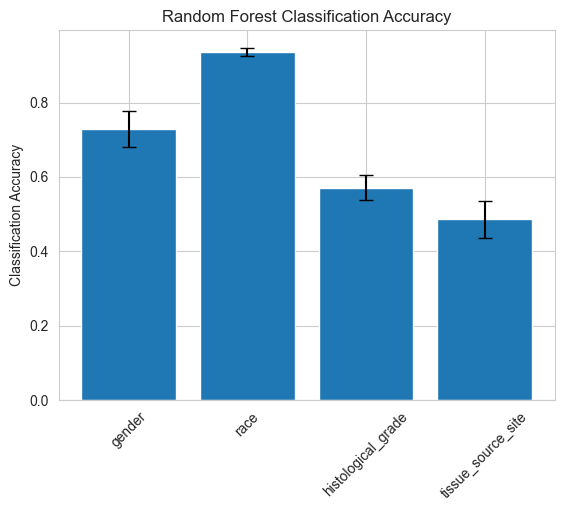

In [91]:
# define embedding methods and labels
embeddings = ["umap", "pca", "tsne", "mds"]
labels = ["gender", "race", "histological_grade", "tissue_source_site"]

# define a function to get the classification accuracy for each embedding and label
def get_classification_accuracy(embedding, label):
    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(embedding, adata.obs[label], test_size=0.2, random_state=0, stratify=adata.obs["tissue_source_site"])
    
    # fit the model
    clf = RandomForestClassifier(oob_score=True).fit(X_train, y_train)
    
    # predict on test data
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    return score

# initialize empty arrays to store classification accuracy for each embedding and label
accuracy_array = np.zeros((4,4))

# loop through embeddings and labels to get classification accuracy
for i, embedding in enumerate(embeddings):
    for j, label in enumerate(labels):
        accuracy_array[i,j] = get_classification_accuracy(adata.obsm[embedding], label)

# calculate mean and standard deviation of accuracy across embeddings for each label
mean_accuracy = np.mean(accuracy_array, axis=0)
std_accuracy = np.std(accuracy_array, axis=0)

# create bar plot of mean accuracy with error bars representing standard deviation
fig, ax = plt.subplots()
ax.bar(labels, mean_accuracy, yerr=std_accuracy, capsize=5, color='C0')
ax.set_ylabel('Classification Accuracy')
ax.set_title('Random Forest Classification Accuracy')
plt.xticks(rotation=45)

plt.show()

<Figure size 1200x800 with 0 Axes>

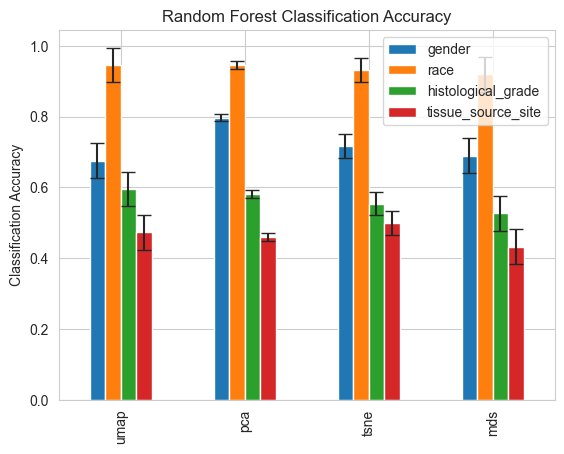

In [92]:
# define embedding methods and labels
embeddings = ["umap", "pca", "tsne", "mds"]
labels = ["gender", "race", "histological_grade", "tissue_source_site"]

# define a function to get the classification accuracy for each embedding and label
def get_classification_accuracy(embedding, label):
    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(embedding, adata.obs[label], test_size=0.2, random_state=0, stratify=adata.obs["tissue_source_site"])
    
    # fit the model
    clf = RandomForestClassifier(oob_score=True).fit(X_train, y_train)
    
    # predict on test data
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    return score

# initialize empty arrays to store classification accuracy for each embedding and label
accuracy_array = np.zeros((4,4))

# loop through embeddings and labels to get classification accuracy
for i, embedding in enumerate(embeddings):
    for j, label in enumerate(labels):
        accuracy_array[i,j] = get_classification_accuracy(adata.obsm[embedding], label)

# create a DataFrame from the accuracy_array
df = pd.DataFrame(accuracy_array, columns=labels, index=embeddings)

# define the figure size and style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# create a grouped bar chart
df.plot(kind='bar', yerr=std_accuracy, capsize=5)

# set the axis labels and title
plt.ylabel('Classification Accuracy')
plt.title('Random Forest Classification Accuracy')

plt.show()

<Figure size 1200x800 with 0 Axes>

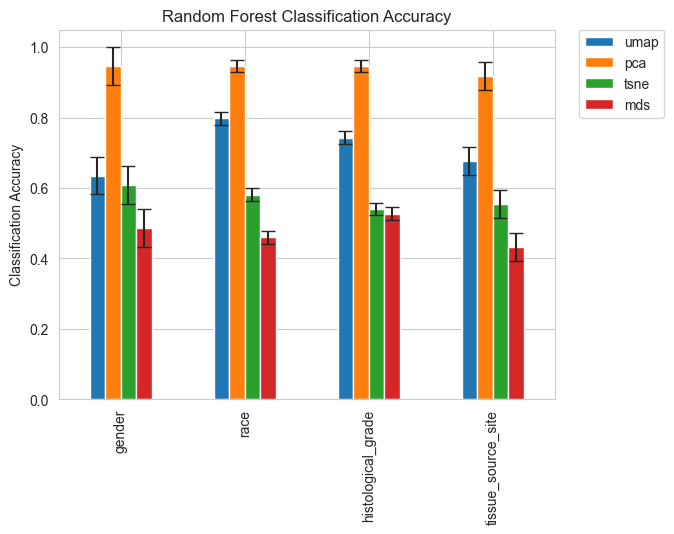

In [76]:
# define embedding methods and labels
embeddings = ["umap", "pca", "tsne", "mds"]
labels = ["gender", "race", "histological_grade", "tissue_source_site"]

# define a function to get the classification accuracy for each embedding and label
def get_classification_accuracy(embedding, label):
    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(embedding, adata.obs[label], test_size=0.2, random_state=0, stratify=adata.obs["tissue_source_site"])
    
    # fit the model
    clf = RandomForestClassifier(oob_score=True).fit(X_train, y_train)
    
    # predict on test data
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    return score

# initialize empty arrays to store classification accuracy for each embedding and label
accuracy_array = np.zeros((4,4))

# loop through embeddings and labels to get classification accuracy
for i, embedding in enumerate(embeddings):
    for j, label in enumerate(labels):
        accuracy_array[i,j] = get_classification_accuracy(adata.obsm[embedding], label)

# create a DataFrame from the accuracy_array
df = pd.DataFrame(accuracy_array, columns=embeddings, index=labels)

# define the figure size and style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# create a grouped bar chart
df.plot(kind='bar', yerr=std_accuracy, capsize=5)

# set the axis labels and title
plt.ylabel('Classification Accuracy')
plt.title('Random Forest Classification Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 

plt.show()

In [93]:
# define embedding methods and labels
embeddings = ["umap", "pca", "tsne", "mds", "OG data"]
labels = ["gender", "race", "histological_grade", "tissue_source_site"]

def get_classification_accuracy(embedding, label):
    # initialize a k-fold cross-validation splitter
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # initialize an empty list to store the accuracy scores for each fold
    scores = []
    
    # loop through each fold
    for train_idx, test_idx in kf.split(embedding, adata.obs[label]):
        # split data into train and test
        X_train, X_test = embedding[train_idx], embedding[test_idx]
        y_train, y_test = adata.obs[label][train_idx], adata.obs[label][test_idx]

        # fit the model
        clf = RandomForestClassifier(oob_score=True).fit(X_train, y_train)

        # predict on test data
        y_pred = clf.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        
        scores.append(score)

    # calculate the mean accuracy across all folds
    mean_score = np.mean(scores)

    return mean_score

# initialize empty arrays to store classification accuracy for each embedding and label
accuracy_array = np.zeros((5,4))

# loop through embeddings and labels to get classification accuracy
for i, embedding in enumerate(embeddings):
    if embedding == "OG data":
        accuracy_array[i,:] = get_classification_accuracy(adata.X, labels)
    else:
        for j, label in enumerate(labels):
            accuracy_array[i,j] = get_classification_accuracy(adata.obsm[embedding], label)

# create a DataFrame from the accuracy_array
df = pd.DataFrame(accuracy_array, columns=labels, index=embeddings)

# define the figure size and style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# create a grouped bar chart
df.plot(kind='bar', yerr=std_accuracy, capsize=5)

# set the axis labels and title
plt.ylabel('Classification Accuracy')
plt.title('Random Forest Classification Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) 

plt.show()

/Users/spaulding/Documents/GitHub/ece204_project1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/spaulding/Documents/GitHub/ece204_project1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/spaulding/Documents/GitHub/ece204_project1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/spaulding/Documents/GitHub/ece204_project1/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multiclass-multioutput' instead.